### Imports & Setup

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [ ]:
# Set up the dataset path
dataset_path = '.'

# Set up saving figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "InceptionResNetV2-DnCNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True) # create the sub-folders if do not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print('> SETUP Done: all saved files are accessible in ', IMAGES_PATH)

> SETUP Done: all saved files are accessible in  .\images\InceptionResNetV2-DnCNN


In [21]:
# Setting all the parameters or hyperparameters
# relative to the inception model
img_size = 128
test_size = 0.3
random_state = 42
validation_split = 0.2
epochs = 20
batch_size = 32
learning_rate = 0.0001
# relative to the DnCNN
denoising_epochs = 5 
denoising_val_split=0.1 
denoising_batch_size=32
denoising_std = 0.1  # Noise standard deviation for synthetic noise

### Loading & preprocessing Data

In [3]:
# DATA LOADING & PREPROCESSING
def load_and_preprocess(img_size, test_size, random_state, date):
    print('> Loading data ...')
    data = np.load(f'{dataset_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')
    labels = pd.read_excel(f'{dataset_path}/labels_rgb.xlsx')
    print("Shape of data images:", data.shape)
    print(f"Shape of labeled data: {labels.shape[0]}:{labels.shape[1]}, header: {labels.columns}")
    y_label = labels['class'].values

    print('> Data and labels loaded')
    print('> Preprocessing Data : remove filler class + Split train/test + Normalisation ... ')

    # Adjusting size mismatch between data and labels (chosen to cut rather than augmenting data)
    min_length = min(data.shape[0], y_label.shape[0])
    data = data[:min_length]
    y_label = y_label[:min_length]

    # Remove filler class (class 0)
    valid_idx = y_label != 0
    data = data[valid_idx]
    y_label = y_label[valid_idx] - 1  # Adjust class index to start from 0

    # Define class names
    class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
    print('Concerned classes: ', class_names)

    # Split data into train and test sets
    train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=test_size, random_state=random_state)

    # Normalize images
    train_images, test_images = train_images / 255.0, test_images / 255.0

    print('> Data Preprocessing Done ')
    return train_images, test_images, train_labels, test_labels, class_names

# Execute an example
date_ex = "8_18"
train_images, test_images, train_labels, test_labels, class_names = load_and_preprocess(img_size, test_size, random_state, date_ex)

> Loading data ...
Shape of data images: (6840, 128, 128, 3)
Shape of labeled data: 6832:3, header: Index(['FID', 'treatment', 'class'], dtype='object')
> Data and labels loaded
> Preprocessing Data : remove filler class + Split train/test + Normalisation ... 
Concerned classes:  ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
> Data Preprocessing Done 


### Add Synthetic Noise to Images
Generate noisy-clean pairs for training the DnCNN.

In [4]:
# Add noise to images
def add_noise(images, noise_type, std):
    if noise_type == "gaussian":
        noisy_images = images + np.random.normal(0, std, images.shape)
        return np.clip(noisy_images, 0.0, 1.0)
    elif noise_type == "salt_pepper":
        noisy_images = images.copy()
        prob = 0.05
        salt = np.random.rand(*images.shape) < prob
        pepper = np.random.rand(*images.shape) < prob
        noisy_images[salt] = 1.0
        noisy_images[pepper] = 0.0
        return noisy_images
    else:
        raise ValueError("Unsupported noise type")

# Execute an example
noisy_images = add_noise(train_images, noise_type="gaussian", std=denoising_std)

### DnCNN Model for Denoising
Define, train, and integrate a DnCNN model.

* Mean Squared Error (MSE) is used as a training metric : Quantifies the average squared difference between pixel intensities.

In [5]:
# DnCNN Model Definition
def build_dncnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation=None)(inputs)
    x = ReLU()(x)
    for _ in range(15):
        x = Conv2D(64, (3, 3), padding='same', activation=None)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
    x = Conv2D(3, (3, 3), padding='same', activation=None)(x)
    outputs = tf.keras.layers.Subtract()([inputs, x])  # Residual Learning
    return Model(inputs, outputs, name="DnCNN")

# Train DnCNN
def train_dncnn(train_images, clean_images, denoising_val_split, denoising_epochs, denoising_batch_size):
    input_shape = train_images.shape[1:]
    dncnn = build_dncnn(input_shape)
    dncnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    print('> Training DnCNN for denoising ...')
    history = dncnn.fit(
        train_images, clean_images,
        validation_split=denoising_val_split,
        epochs=denoising_epochs,
        batch_size=denoising_batch_size,
        verbose=1
    )
    print('> DnCNN Training Complete!')
    return dncnn, history

# Execute an example
dcnn, dcnn_history = train_dncnn(noisy_images, train_images, denoising_val_split, denoising_epochs, denoising_batch_size)
dcnn.summary()

> Training DnCNN for denoising ...
Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1227s 12s/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 992s 9s/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1018s 10s/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1408s 13s/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1607s 15s/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0046 - val_mse: 0.0046
> DnCNN Training Complete!


Model: "DnCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_5[0][0]  

 Total params: 1,680,011 (6.41 MB)

 Trainable params: 559,363 (2.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 1,118,728 (4.27 MB)

### Visualize & Evaluate Noisy and Denoised Images
While MSE is used for training, other evaluation metrics like PSNR and SSIM are often used for post-training evaluation.

* PSNR (Peak Signal-to-Noise Ratio) : Compares the original and denoised images to measure quality improvement. Higher PSNR indicates better denoising.

* SSIM (Structural Similarity Index) : Considers human perception by measuring perceptual similarity between original and denoised images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


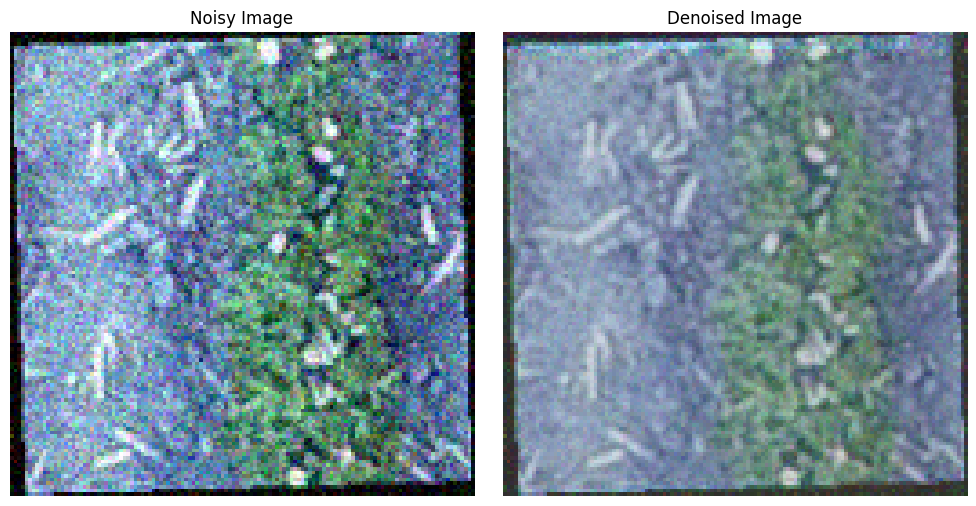

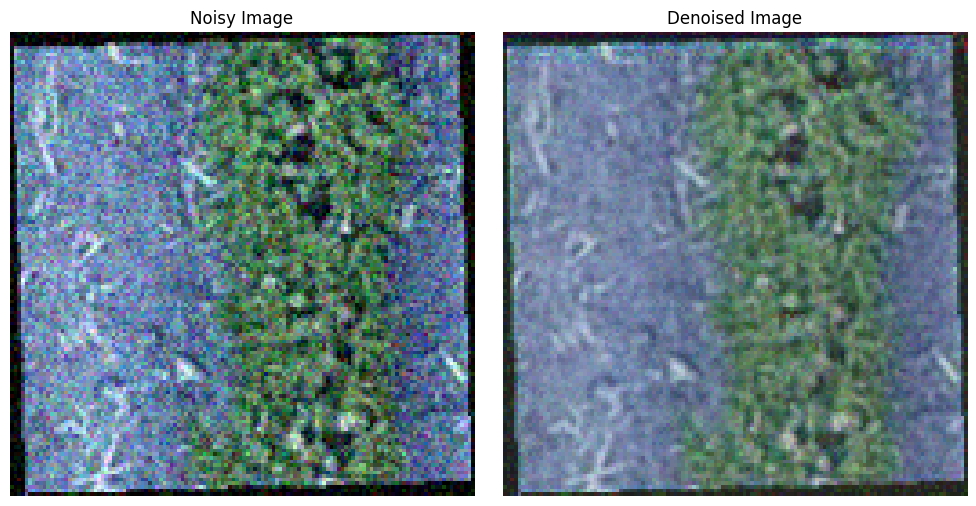

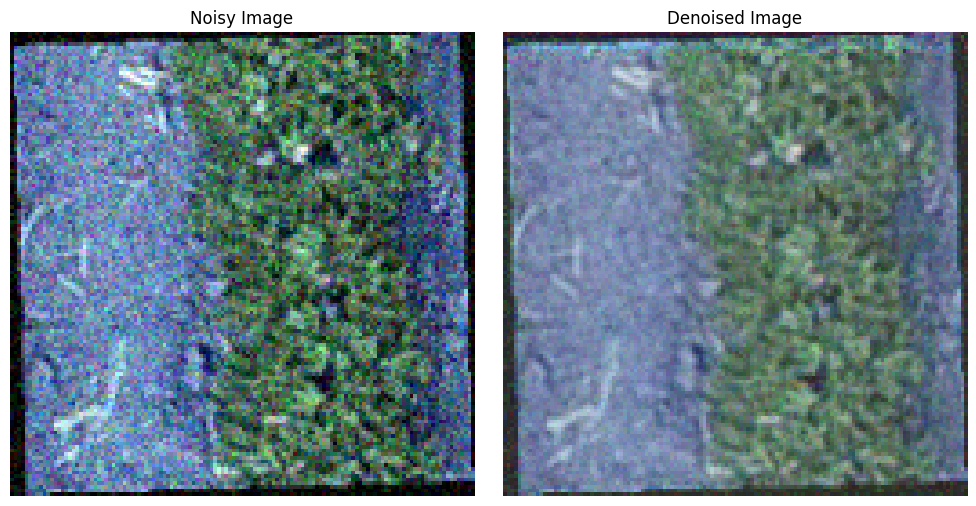

Image 1:
  PSNR (Noisy vs. Denoised): 72.13
  SSIM (Noisy vs. Denoised): 1.00

Image 2:
  PSNR (Noisy vs. Denoised): 72.28
  SSIM (Noisy vs. Denoised): 1.00

Image 3:
  PSNR (Noisy vs. Denoised): 72.31
  SSIM (Noisy vs. Denoised): 1.00



In [10]:
# Set sample size
sample_size = 3

# Visualize noisy and denoised images
def plot_images(noisy, denoised, indices):
    """
    Plots a comparison of noisy and denoised images for the given indices.
    """
    for idx in indices:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(array_to_img(noisy[idx]))
        axes[0].set_title("Noisy Image")
        axes[0].axis('off')
        axes[1].imshow(array_to_img(denoised[idx]))
        axes[1].set_title("Denoised Image")
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

# Example: Visualize and evaluate a random image sample
random.seed(42)  # Set seed for reproducibility

# Select random indices for the sample
sample_indices = random.sample(range(len(noisy_images)), sample_size)
noisy_sample = [noisy_images[i] for i in sample_indices]

# Predict denoised images
denoised_sample = dcnn.predict(np.array(noisy_sample))

# Visualize the selected sample
plot_images(noisy_sample, denoised_sample, indices=range(sample_size))

# Evaluate metrics for the sampled images
def evaluate_metrics(noisy, denoised):
    """
    Calculates and prints PSNR and SSIM metrics for noisy and denoised images.
    """
    psnr_values, ssim_values = [], []
    for n, d in zip(noisy, denoised):
        n, d = np.array(n), np.array(d)
        psnr_values.append(psnr(n, d, data_range=255))
        ssim_values.append(ssim(n, d, data_range=255, win_size=3, channel_axis=-1))
    
    # Print metrics for each sample
    for i, (p, s) in enumerate(zip(psnr_values, ssim_values)):
        print(f"Image {i + 1}:")
        print(f"  PSNR (Noisy vs. Denoised): {p:.2f}")
        print(f"  SSIM (Noisy vs. Denoised): {s:.2f}")
        print()

evaluate_metrics(noisy_sample, denoised_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


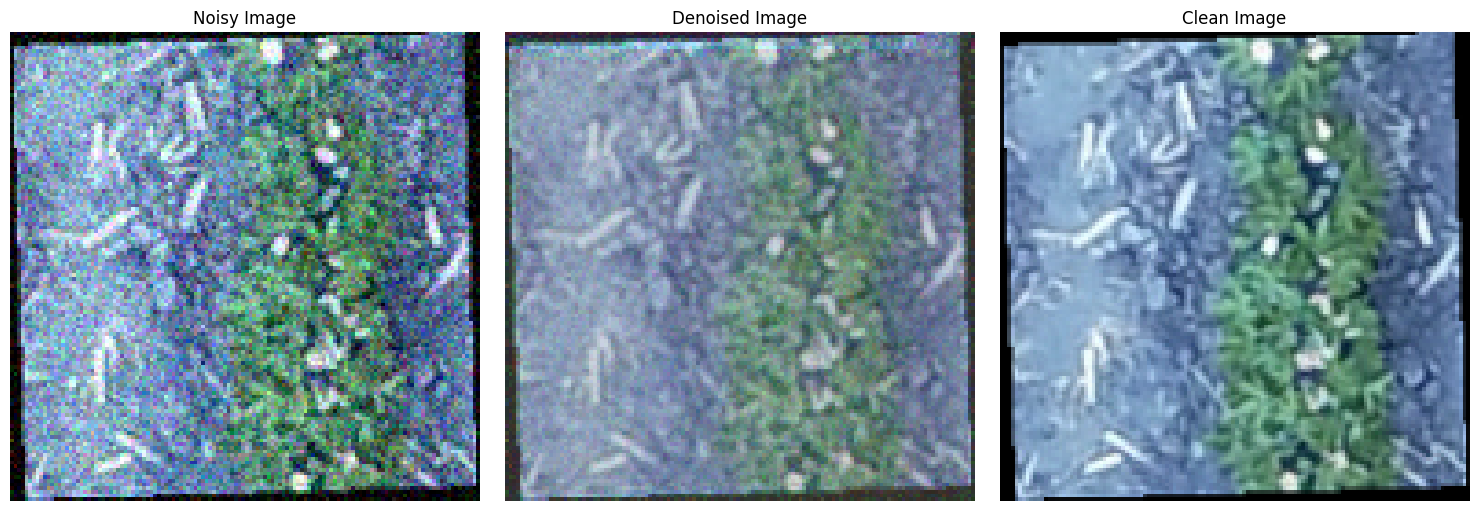

Image 1:
  PSNR (Noisy): 68.39, PSNR (Denoised): 71.64
  SSIM (Noisy): 1.00, SSIM (Denoised): 1.00



In [17]:
sample_size = 1

# Visualize noisy, denoised, and clean images
def plot_images(noisy, denoised, clean, indices):
    """
    Plots a comparison of noisy, denoised, and clean images for the given indices.
    """
    for idx in indices:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(array_to_img(noisy[idx]))
        axes[0].set_title("Noisy Image")
        axes[0].axis('off')
        axes[1].imshow(array_to_img(denoised[idx]))
        axes[1].set_title("Denoised Image")
        axes[1].axis('off')
        axes[2].imshow(array_to_img(clean[idx]))
        axes[2].set_title("Clean Image")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()

# Example: Visualize and evaluate a random image sample
random.seed(42)  # Set seed for reproducibility

# Select 5 random indices
sample_indices = random.sample(range(len(train_images)), sample_size)
noisy_sample = [noisy_images[i] for i in sample_indices]
clean_sample = [train_images[i] for i in sample_indices]

# Predict denoised images
denoised_sample = dcnn.predict(np.array(noisy_sample))

# Visualize the selected sample
plot_images(noisy_sample, denoised_sample, clean_sample, indices=range(sample_size))

# Evaluate metrics for the sampled images
def evaluate_metrics(clean, noisy, denoised):
    """
    Calculates and prints PSNR and SSIM metrics for noisy and denoised images.
    """
    psnr_noisy, psnr_denoised, ssim_noisy, ssim_denoised = [], [], [], []
    for c, n, d in zip(clean, noisy, denoised):
        c, n, d = np.array(c), np.array(n), np.array(d)
        psnr_noisy.append(psnr(c, n, data_range=255))
        psnr_denoised.append(psnr(c, d, data_range=255))
        ssim_noisy.append(ssim(c, n, data_range=255, win_size=3, channel_axis=-1))
        ssim_denoised.append(ssim(c, d, data_range=255, win_size=3, channel_axis=-1))
        
    
    # Print metrics for each sample
    for i, (pn, pd, sn, sd) in enumerate(zip(psnr_noisy, psnr_denoised, ssim_noisy, ssim_denoised)):
        print(f"Image {i + 1}:")
        print(f"  PSNR (Noisy): {pn:.2f}, PSNR (Denoised): {pd:.2f}")
        print(f"  SSIM (Noisy): {sn:.2f}, SSIM (Denoised): {sd:.2f}")
        print()

evaluate_metrics(clean_sample, noisy_sample, denoised_sample)

### Inception Model building
Using the denoised images (DnCNN outputs) as inputs or training images for our main inception model (based on InceptionResNetV4)

In [22]:
# MODEL BUILDING & TRAINING
def build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate):
    print('> Building the model ... ')

    # Build the model using InceptionResNetV2
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Freeze base model layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print('> Training in progress ... ')
    # Train the model
    history = model.fit(train_images,
                        train_labels,
                        validation_split = validation_split,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1)

    print('> End of Training !')
    return model, history

# Execute
model, history = build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate)
#model.summary()

> Building the model ... 
> Training in progress ... 
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.3341 - loss: 1.3898 - val_accuracy: 0.5073 - val_loss: 1.0916
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5732 - loss: 0.9596 - val_accuracy: 0.6361 - val_loss: 0.8395
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7116 - loss: 0.6876 - val_accuracy: 0.6653 - val_loss: 0.7763
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8119 - loss: 0.4785 - val_accuracy: 0.6640 - val_loss: 0.9589
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8872 - loss: 0.3093 - val_accuracy: 0.7012 - val_loss: 0.9099
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9399 - loss: 0.1726 - val_accuracy: 0.6985 - val_loss: 1.0050
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 77s 807ms/step - accuracy: 0.9595 - loss: 0.1388 - val_accuracy: 0.6853 - val_loss: 1.2141
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 56s 593ms/step - 

### Evaluating the model

> Lets evaluate the model now ... 


<>:22: SyntaxWarning: invalid escape sequence '\C'
<>:22: SyntaxWarning: invalid escape sequence '\C'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10332\1116904636.py:22: SyntaxWarning: invalid escape sequence '\C'
  report_path = f"{IMAGES_PATH}\Classification_Report_{date}.txt"


51/51 - 35s - 687ms/step - accuracy: 0.7216 - loss: 1.1797
Test Accuracy for 8_18: 0.72
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 768ms/step
Saving figure Confusion_matrix_8_18
                 precision    recall  f1-score   support

        rainfed       0.79      0.76      0.78       424
fully irrigated       0.81      0.80      0.81       399
percent deficit       0.63      0.62      0.62       404
     time delay       0.66      0.70      0.68       386

       accuracy                           0.72      1613
      macro avg       0.72      0.72      0.72      1613
   weighted avg       0.72      0.72      0.72      1613

Saving figure Training_Accuracy_8_18


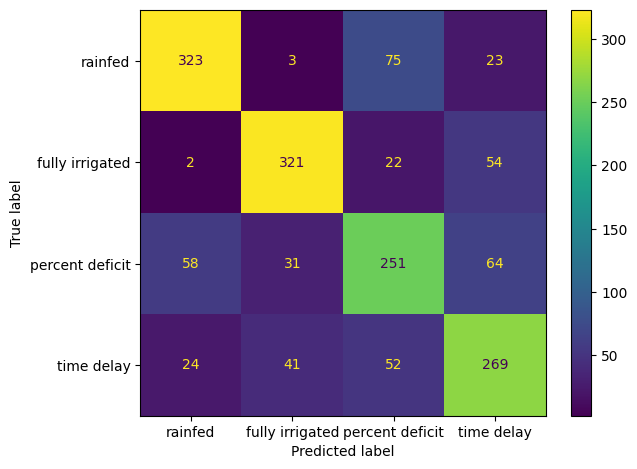

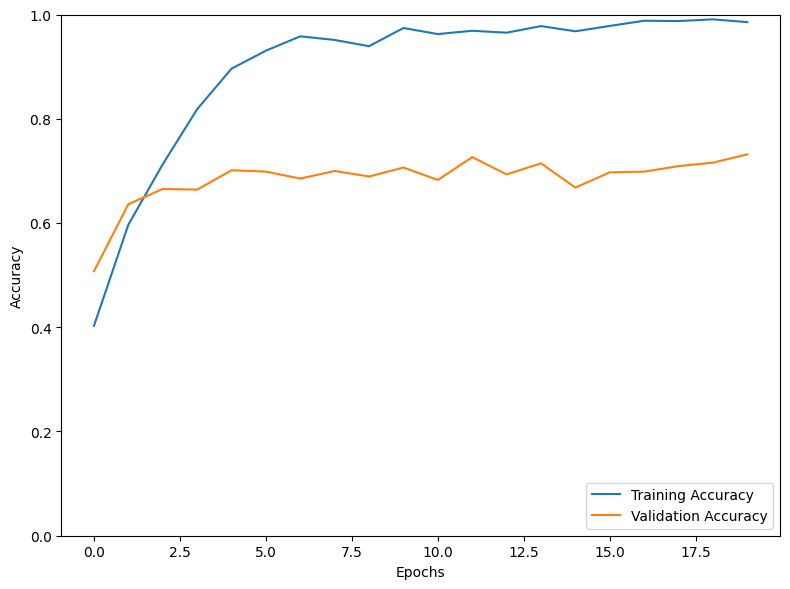

In [23]:
# MODEL EVALUATION
def evaluate_model(model, test_images, test_labels, date, history):
    print('> Let''s evaluate the model now ... ')

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test Accuracy for {date}: {test_acc:.2f}")

    # Predictions and classification report
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(test_labels, pred_classes, display_labels=class_names)
    save_fig(f"Confusion_matrix_{date}")

    # Classification report
    report = classification_report(test_labels, pred_classes, target_names=class_names)
    print(report)

    # Save the classification report
    report_path = f"{IMAGES_PATH}\Classification_Report_{date}.txt"
    with open(report_path, "w") as f:
        f.write(report)

    # Plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    save_fig(f"Training_Accuracy_{date}")

evaluate_model(model, test_images, test_labels, date_ex, history)

### Test and Predict for a Specific Image

> Testing a single image ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted Class: percent deficit
True Class: percent deficit


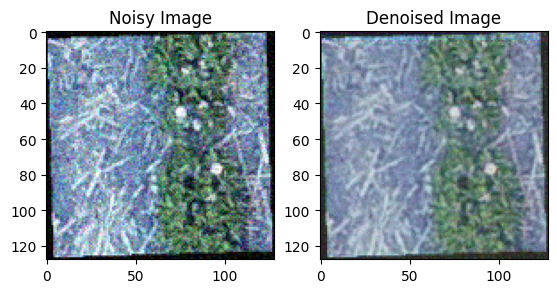

In [ ]:
# Predict for a specific image
def test_single_image(model, dncnn, idx_image):
    print('> Testing a single image ...')
    #noisy_image = add_noise(image[None, ...], "salt_pepper", denoising_std)
    noisy_image = add_noise(test_images[idx_image][None, ...], "gaussian", denoising_std)
    denoised_image = dncnn.predict(noisy_image)
    prediction = model.predict(denoised_image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    true_class = class_names[test_labels[idx_image]]
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"True Class: {true_class}")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(array_to_img(noisy_image[0]))
    plt.title("Noisy Image")
    plt.subplot(1, 3, 2)
    plt.imshow(array_to_img(denoised_image[0]))
    plt.title("Denoised Image")
    plt.show()

# Example usage: test_images[0] --> test_images[1612] because len(test_images)=1613
test_single_image(model, dcnn, 5)